This notebook is a quick guide through applying deep learning to estimating the frequency of a quantized sinusoid using deep learning. The associated paper is [here](https://ieeexplore.ieee.org/abstract/document/9154214), or if you do not have access, feel free to send me an email and I would be happy to send you a copy. 

For citation purposes please use the paper citation:

@INPROCEEDINGS{Dreifuerst2020,<p>
  author={R. M. {Dreifuerst} and R. W. {Heath} and M. N. {Kulkarni} and J. {Charlie}},<p>
  booktitle={2020 IEEE 21st International Workshop on Signal Processing Advances in Wireless Communications (SPAWC)}, <p>
  title={Deep Learning-based Carrier Frequency Offset Estimation with One-Bit ADCs}, <p>
  year={2020},
  pages={1-5},
  doi={10.1109/SPAWC48557.2020.9154214}}

In [2]:
!pip install spectrum

import numpy as np
import matplotlib

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn import model_selection

from scipy.fftpack import fft
import scipy.signal
from spectrum import pmusic

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K

import pickle
from functools import partial


## set up plotting
matplotlib.rcParams['figure.figsize'] = [14, 10]

     |████████████████████████████████| 235kB 9.1MB/s 
  Created wheel for spectrum: filename=spectrum-0.8.0-cp36-cp36m-linux_x86_64.whl size=234761 sha256=db0062daf00f15394f048f00a457f276e5adb2e6acd39e500175ce77c6c4057d
  Stored in directory: /root/.cache/pip/wheels/62/de/fd/94dc5ad0a7d93803f4cb4a26744d21e91ac4bf0a63004d2b14
Successfully built spectrum


In [6]:
#@title Function list, double click to expand

################################# Data Generation #################################################
def data_generator(min_fc, max_fc, phase_offset=0, amplitude = 1, n=24, fs=4000):
    """
    Generates data which has a carrier frequency between min_fc and max_fc
    :param min_fc: minimum fc possible
    :param max_fc: maximum fc possible
    :param n: number of points to generate
    :param phase_offset: The desired phase offset in degrees
    :param fs: The sampling frequency in Hertz for calculating digital frequency
    :return: One set of data with fc randomly between min_fc and max_fc of size n, and the digital frequency
    """
    
    t = np.arange(0, n)/fs
    fc = np.random.uniform(min_fc, max_fc)
    digital_freq = fc/fs
    x = amplitude*np.exp(1j*(2*np.pi*fc*t + phase_offset/180*np.pi))

    return np.asarray(x), digital_freq


def generate_noise(data, snr=20):
    """
    generates noisy data from clean data and a signal to noise ratio
    :param data: clean input data
    :param snr: Signal to Noise ratio in dB
    :return: noisy data
    """
    sig_power = 1.0/len(data)*np.dot(data.conj().T, data).real
    sig_power_db = 10*np.log10(sig_power)
    noise_power_db = sig_power_db - snr
    noise_power = 10**(noise_power_db/10.0)
    std = np.sqrt(noise_power/2.0)
    noise_comp = np.random.normal(loc=0, scale=std, size=(len(data), 2)).astype(np.float64)

    noise = np.complex64(noise_comp[:, 0] + 1j * noise_comp[:, 1])
    noisy_data = np.asarray(np.add(data, noise).astype(np.complex64))

    return np.asarray(noisy_data), std


def convert_complex_to_real(data):
    """
    Converts complex vector data into a matrix with two seperate real values
    """
    new_data = np.zeros((len(data), 2))
    new_data[:, 0] = data.real
    new_data[:, 1] = data.imag
    return np.asarray(new_data)

def convert_real_to_complex(data):
    """
    Converts a matrix of real data into a single vector with complex data
    """
    new_data = np.zeros((len(data)))
    new_data = data[:, 0] + 1j*data[:, 1]
    return np.asarray(new_data)

# need to convert values like [3, 5, 2] -> [[0, 0, 1, 0, 0], [0, 0, 0, 0, 1] ..]
def to_one_hot(signal_set):
    m = len(signal_set)
    output = np.zeros((m, 6))
    lookup = np.array([
                       [1, 0, 0, 0, 0, 0],
                       [0, 1, 0, 0, 0, 0],
                       [0, 0, 1, 0, 0, 0],
                       [0, 0, 0, 1, 0, 0],
                       [0, 0, 0, 0, 1, 0],
                       [0, 0, 0, 0, 0, 1]
    ])
    for i in range(m):
        output[i, :] = lookup[signal_set[i]-1]
    return output


def un_one_hot(one_hot_mat):
    output = tf.argmax(one_hot_mat, axis=1)
    return tf.cast(output, dtype=tf.float32)


def build_dataset(min_fc, max_fc, size, fs, amplitude=1, n=24, phase_offset=None, min_snr=None, max_snr=None, split_real_imag=False, quantizer=None, bits=1):
    """
    Generates a dataset with noise over many frequencies
    :param min_fc: Minimum carrier frequency in Hertz
    :param max_fc: Maximum carrier frequency in Hertz
    :param size: Number of different data generations to run
    :param fs: Sampling frequency in Hertz
    :param amplitude: Amplitude of the signals before noise
    :param n: Number of samples per data generation
    :param phase_offset: None, otherwise randomly generated phase offset in data from 0 to 360 degrees
    :param noise_snr: None for clean data or the SNR of noisy data to generate with
    :param split_real_imag: Whether the returned data should be complex or two real sets
    :return: dataset(size, n, ?), digital frequencies
    """
    dataset = np.zeros((size, n), dtype=np.complex64)
    frequencies = np.zeros((size, 1), dtype=np.float64)
    for i in range(size):
        # random phase offset
        if phase_offset is not None:
            offset = np.random.randint(0, 360)
            dataset[i], frequencies[i] = data_generator(min_fc=min_fc, max_fc=max_fc, phase_offset=offset, amplitude=amplitude, n=n, fs=fs)
        else:
            dataset[i], frequencies[i] = data_generator(min_fc=min_fc, max_fc=max_fc, amplitude=amplitude, n=n, fs=fs)
            
        if min_snr is not None:
            noise_snr = np.random.uniform(low=min_snr, high=max_snr, size=1)
            dataset[i], _ = generate_noise(dataset[i], noise_snr)
            
        if quantizer is not None:
            dataset[i][:], _ = general_quantizer(data=dataset[i][:], minimum=-amplitude, maximum=amplitude, bits=bits)

    if split_real_imag != False:
        newdataset = np.zeros((size, n, 2))
        for i in range(size):
            newdataset[i, :, :] = convert_complex_to_real(dataset[i, :])

        dataset = np.asarray(newdataset, dtype=np.float64)
        frequencies = np.asarray(frequencies)
        
    return (dataset, frequencies)


################################### Quantizer Functions #################################################
def general_quantizer(data, minimum=-1, maximum=1, bits=1, quantizer_func=None):
    """
    Generic quantizer function to call other quantizer functions
    :param data: Time domain input data
    :param minimum: Minimum input data value
    :param maximum: Maximum input data value
    :param bits: Number of bits for the quantizer
    :param quantizer_func: The function which will generate the quantizer levels (data, minimum, maximum, bits)
    :return: (quantized data, quantizer levels)
    """
    data = np.asarray(data)
    if quantizer_func is None:
        levels = np.asarray(linear_quantizer(data=data, minimum=minimum, maximum=maximum, bits=bits))
    else:
        try:
            levels = np.asarray(quantizer_func(data=data, minimum=minimum, maximum=maximum, bits=bits))
        except Exception as e:
            print("Non-linear function not given, switching to linear")
            levels = linear_quantizer(data=data, minimum=minimum, maximum=maximum, bits=bits)

    quantized_data = np.zeros_like(data)
    # determine if data is real, complex
    if isinstance(data, np.complex128) or isinstance(data, complex):
        for t, amplitude in enumerate(data):
            idx = (np.abs(levels - amplitude)).argmin()
            quantized_data[t] = levels[idx]

    else:
        quantized_data = np.zeros((len(data), 2))

        for t, amplitude in enumerate(data.real):
            idx = (np.abs(levels - amplitude)).argmin()
            quantized_data[t][0] = levels[idx]
        for t, amplitude in enumerate(data.imag):
            idx = (np.abs(levels - amplitude)).argmin()
            quantized_data[t][1] = levels[idx]

        quantized_data = np.add(quantized_data[:, 0], 1j * quantized_data[:, 1])

    return np.asarray(quantized_data), levels


def linear_quantizer(data, minimum=1, maximum=1, bits=1):
    """
    A simple linear quantizer giving even spaced levels between min and max
    :param data: time domain input data
    :param minimum: minimum level desired
    :param maximum: Non-inclusive maximum level desired
    :param bits: number of bits used
    :return: linear levels for the quantizer
    """
    levels = np.linspace(minimum, maximum, 2**bits)
    return levels


def non_linear_quantizer(data, minimum=-1, maximum=1, bits=1):
    """
    Non-linear quantizer, can be redone for more advanced algorithms, currently is a linear of the inner 1/2 of the range
    :param data: Time domain input data
    :param minimum: Minimum quantizer input
    :param maximum: Maximum quantizer input
    :param bits: Number of bits to use
    :return: quantizer levels
    """
    scale = maximum - minimum
    levels = np.zeros(2**bits)
    if bits > 2:
        adj_min = minimum + scale/4
        adj_max = maximum - scale/4
        levels[0] = adj_min
        levels[1:] = np.linspace(adj_min, adj_max, 2**bits-1)
        levels[-1] = adj_max
    return levels


###################################### General Signal Processing #############################################
def plot_over_snr(data, snr_min, snr_max, fs, min_fc, max_fc, estimators=None, names=None, phase=None, quantizer=None, bits=1, monte_carlos=1):
    """
    Plots the estimator performance over a range of SNR values
    :param data: Time domain, ideal data
    :param snr_min: Minimum SNR value to test
    :param snr_max: Maximum SNR value to test
    :param fs: Sampling frequency
    :param min_fc: Minimum carrier frequency in Hertz
    :param max_fc: Maximum carrier frequency in Hertz
    :param estimators: List of estimator function taking (data, fs)
    :param names: List of names of the estimators
    :param quantizer: None, or else applies the linear quantizer
    :param phase: None, or applies uniformly distributed phase offset
    :param bits: number of bits for the quantizer to use
    :param Monte_Carlos: Number of simulations to run and average over
    :return: SNRs used and the MSE for the estimators
    """

    snrs = np.linspace(snr_min, snr_max, (snr_max-snr_min)*2)
    amplitude = np.max(np.absolute(data))

    plt.title(f"10*log10(MSE) vs SNR for frequency estimation")
    plt.xticks(np.arange(snr_min, snr_max+1e-8, step=(snr_max-snr_min)/5))
    plt.xlabel("SNR (dB)")
    plt.ylabel("10*log10(MSE) (dB)")

    # true_snr = np.zeros((len(snrs), monte_carlos))
    num_estimators = len(estimators)
    fcs = np.zeros((num_estimators, len(snrs), monte_carlos), dtype=np.float64)


    if estimators is not None:
        estimators_predictions = np.zeros((num_estimators, len(snrs), monte_carlos), dtype=np.float64)
        for estimator in range(num_estimators):
            for sim in range(monte_carlos):
                for snr_num, snr in enumerate(snrs):
                    new_data, fcs[estimator, snr_num, sim] = data_generator(min_fc, max_fc, amplitude=amplitude, n=len(data), fs=fs)

                    if phase is not None:
                        phase_shift = np.random.randint(0, 360)
                        new_data, fcs[estimator, snr_num, sim] = data_generator(min_fc, max_fc, phase_offset=phase_shift, amplitude=amplitude, n=len(data), fs=fs)

                    noisy_data, _ = generate_noise(new_data, snr)

                    # true_snr[snr_num, sim] = calc_snr(data, noisy_data)

                    if quantizer is not None:
                        noisy_data, levels = general_quantizer(data=noisy_data, minimum=-amplitude, maximum=amplitude, bits=bits, quantizer_func=quantizer)
                        plt.title(f"10log10(MSE) vs SNR for frequency estimation with {bits}-bit Quanitization")

                    estimators_predictions[estimator, snr_num, sim] = estimators[estimator](data=noisy_data)

    mses = np.zeros((num_estimators, len(snrs)), dtype=np.float64)

    # snrs = [np.average(true_snr[i, :]) for i in range(len(snrs))]
    snrs_lin = [10.0**(snrs[i]/10.0) for i in range(len(snrs))]

    for estimator in range(num_estimators):
        for snr_num, snr in enumerate(snrs):
            # calculate MSE for each estimator at each SNR
            mses[estimator][snr_num] = np.float64(mean_squared_error(fcs[estimator, snr_num, :], estimators_predictions[estimator, snr_num, :]))
            # apply 10log(mse) for each estimator at each SNR
            mses[estimator][snr_num] = np.float64(10.0 * np.log10((mses[estimator][snr_num])))
        plt.plot(snrs, mses[estimator], '--')

    if quantizer is None:
        CRB = np.zeros(len(snrs))
        CRB = [6.0/(snrs_lin[i] * (len(data) * (len(data)**2 - 1))) for i in range(len(snrs))]
        CRB = [-16.5 + 10.0 * np.log10((CRB[i])) for i in range(len(CRB))]

        plt.plot(snrs, CRB)
        names.append("CRB")

    plt.xticks(np.arange(snr_min, snr_max+1.0e-5, step=0.1*(snr_max-snr_min)))
    plt.legend(names, loc='best')
    plt.grid()
    plt.show()
    return (snrs, mses)


def plot_over_snr_DL(data, snr_min, snr_max, fs, min_fc, max_fc, estimators=None, phase=None, names=None, quantizer=None, bits=1, monte_carlos=1):
    """
    Plots the estimator performance over a range of SNR values
    :param data: Time domain, ideal data
    :param snr_min: Minimum SNR value to test
    :param snr_max: Maximum SNR value to test
    :param fs: Sampling frequency
    :param min_fc: Minimum carrier frequency in Hertz
    :param max_fc: Maximum carrier frequency in Hertz
    :param estimators: List of estimator function taking (data, fs)
    :param names: List of names of the estimators
    :param quantizer: None, or else applies the linear quantizer
    :param phase: None, or applies uniformly distributed phase offset
    :param bits: number of bits for the quantizer to use
    :param Monte_Carlos: Number of simulations to run and average over
    :return: SNRs used and the MSE for the estimators
    """

    snrs = np.linspace(snr_min, snr_max, (snr_max-snr_min)*2)
    amplitude = np.max(np.absolute(data))

    plt.title(f"10*log10(MSE) vs SNR for frequency estimation")
    plt.xticks(np.arange(snr_min, snr_max+1e-8, step=(snr_max-snr_min)/5))
    plt.xlabel("SNR (dB)")
    plt.ylabel("10*log10(MSE) (dB)")

    noisy_data = np.zeros((len(snrs), monte_carlos, len(data)))
    fcs = np.zeros((len(snrs), monte_carlos), dtype=np.float64)
    
    if estimators is not None:
        num_estimators = len(estimators)
        estimators_predictions = np.zeros((num_estimators, len(snrs), monte_carlos))
        # gather all data first for DL
        for sim in range(monte_carlos):
            for snr_num, snr in enumerate(snrs):
                new_data, fcs[snr_num, sim] = data_generator(min_fc, max_fc, amplitude=amplitude, n=len(data), fs=fs)

                if phase is not None:
                    phase_shift = np.random.randint(0, 360)
                    new_data, fcs[snr_num, sim] = data_generator(min_fc=min_fc, max_fc=max_fc, phase_offset=phase_shift, amplitude=amplitude, n=len(data), fs=fs)

                noisy_data[snr_num, sim, :], _ = generate_noise(new_data, snr)

                if quantizer is not None:
                    noisy_data[snr_num, sim, :], levels = general_quantizer(data=noisy_data[snr_num, sim, :], minimum=-amplitude, maximum=amplitude, bits=bits, quantizer_func=quantizer)
                    plt.title(f"10log10(MSE) vs SNR for frequency estimation with {bits}-bit Quanitization")

    mses = np.zeros((num_estimators, len(snrs)))
 
    for estimator in range(num_estimators):
        for snr_num, snr in enumerate(snrs):
            # calculate MSE for each estimator at each SNR
            mses[estimator][snr_num] = mean_squared_error(fcs[snr_num, :], estimators[estimator](noisy_data[snr_num, :, :]))
            # apply 10log(mse) for each estimator at each SNR
            mses[estimator][snr_num] = np.float64(10.0 * np.log10((mses[estimator][snr_num])))
        plt.plot(snrs, mses[estimator], '--')


    plt.xticks(np.arange(snr_min, snr_max+1.0e-5, step=0.1*(snr_max-snr_min)))
    plt.legend(names, loc='best')
    plt.grid()
    plt.show()
    return (snrs, mses)


def calc_snr(clean_data, noisy_data):
    """
     Calculates the SNR from a clean data and noisy data set
    :param clean_data: time domain data without noise
    :param noisy_data: time domain data with noise
    :return: Signal to Noise ratio
    """
    noise = np.subtract(noisy_data, clean_data)
    S = 1/len(clean_data)*np.dot(clean_data.conj().T, clean_data).real
    sig_power_db = 10*np.log10(S)
    N = 1/len(noisy_data)*np.dot(noise.conj().T, noise).real
    noise_power_db = 10*np.log10(N)

    SNR = 10*np.log10(S/N)
    # print(f"SNR ={S/N:.2f} which is {SNR:.2f}db and should equal {sig_power_db - noise_power_db:.2f}")
    return SNR


def plot_spectrum(clean_data, y):
    """
    Plots the spectrum for a set of data y with carrier frequency fc
    :param clean_data: clean data to measure against
    :param y: Input data, can be complex
    :param fc: Signal carrier frequency/upper frequency
    :return: SNR for the signal
    """
    dfft = np.absolute(np.fft.fft(y, n = 1024))
    frequencies =np.fft.fftfreq(1024)
    plt.plot(frequencies, 10*np.log10(dfft+1*10**-10))
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('|Y(f)| [dB]')
    plt.show()
    mle_freq = Periodogram_estimator(y)
    print(f"Periodogram peak frequency is {mle_freq:.4f}")
    return calc_snr(clean_data, y)


def interpolation(freqs, values):
    """
    used for interpolating results from periodogram
    :param freqs: Top 3 frequencies
    :param values: Top 3 values for the frequencies
    :return: interpolated frequency
    """

    a, b, c = calc_parabola_vertex(freqs, values)
    return -b/(2.0*a)


def calc_parabola_vertex(freqs, values):
    '''
    Adapted and modifed to get the unknowns for defining a parabola:
    http://stackoverflow.com/questions/717762/how-to-calculate-the-vertex-of-a-parabola-given-three-points
    '''
    x1 = freqs[0]
    x2 = freqs[1]
    x3 = freqs[2]
    y1 = values[0]
    y2 = values[1]
    y3 = values[2]

    denom = np.float64((x1-x2) * (x1-x3) * (x2-x3))
    a = np.float64((x3 * (y2-y1) + x2 * (y1-y3) + x1 * (y3-y2))) / denom
    b = np.float64((x3*x3 * (y1-y2) + x2*x2 * (y3-y1) + x1*x1 * (y2-y3))) / denom
    c = np.float64((x2 * x3 * (x2-x3) * y1+x3 * x1 * (x3-x1) * y2+x1 * x2 * (x1-x2) * y3)) / denom

    return a, b, c


##################################### Estimator Functions ############################################
def CramerRaoBound(n=16, wmin=0.2, wmax=0.25, smin=-20, smax=40):
    snrs_db = np.linspace(smin, smax, num=4*(smax-smin))
    snrs = 10**(snrs_db/10.0)
    crb1 = 7.36/(np.sqrt(snrs)*n**3)
    crb2 = 9.42/(snrs*n**3)
    crb = np.maximum(crb1, crb2)
    factor = (wmax-wmin)/np.pi
    crb = factor**2*crb
    crb = 10*np.log10(crb)
    return snrs_db, crb


##################################### Frequency Estimators ############################################
def WPA_estimator_1(data):
    """
    Estimates the frequency of an input data set using the weighted phase averager
    :param data: Input time domain data
    :return: The highest estimated digital frequency
    """
    data = data.astype(np.complex128)
    n = np.float64(len(data))
    w_t = np.array([], dtype=np.float64)
    w_hat = np.float64(0.0)
    data_conj = np.copy(np.conj(data)).astype(np.complex128)
    data_conj = data_conj[:-1]
    data = data[1:].astype(np.complex128)  # remove the first value so that it will be data_conj[t]*data[t+1]

    for t in range(int(n)-1):
        w_t = np.append(w_t, ((3.0 / 2.0) * n / (n ** 2.0 - 1.0) * (1.0 - ((np.float64(t) - (n / 2.0 - 1.0)) / (n / 2.0)) ** 2.0)))

    w_hat = np.float64(np.sum(np.multiply(w_t, np.angle(np.multiply(data_conj, data))))/(2.0*np.pi).real)
    # print(w_hat)
    return w_hat


def Welchs_Rect_Periodogram(data):
    """
    Implements Welch's method of periodogram with rectangular window
    :param data: input time domain data
    :param fs: sampling frequency
    :return: highest frequency peak of the periodogram
    """
    length = 2**15
    frequencies, dfft = np.absolute(scipy.signal.welch(data, nfft=length, window='boxcar', nperseg=len(data)//2), dtype=np.float128)
    interp = False

    # interpolate from top 3 frequencies
    idx = np.argmax(np.abs(dfft))
    
    if interp is True:
        if idx == length-1:
            mle_freq = frequencies[idx]

        else:
            indices = [idx-1, idx, idx+1]
            freqs = frequencies[indices].astype(np.float64)
            values = np.abs(dfft[indices]).astype(np.float64)

            mle_freq = interpolation(freqs, values)
    else:
        return frequencies[idx]
        
    return mle_freq


def Periodogram_estimator(data):
    """
    Implements the MLE error for frequency estimation, which is the periodogram method
    :param data: input time domain data
    :param fs: sampling frequency
    :return: highest frequency peak of the periodogram
    """
    length = 2**15
    dfft = np.absolute(fft(np.complex128(data), n=length), dtype=np.float128)
    frequencies = np.float128(np.fft.fftfreq(length))
    interp = False

    # interpolate from top 3 frequencies
    idx = np.argmax(np.abs(dfft))
    
    if interp is True:
        if idx == length-1:
            mle_freq = frequencies[idx]

        else:
            indices = [idx-1, idx, idx+1]
            freqs = frequencies[indices].astype(np.float64)
            values = np.abs(dfft[indices]).astype(np.float64)

            mle_freq = interpolation(freqs, values)
    else:
        return frequencies[idx]
        
    return mle_freq


def Music_estimator(data):
    """
    Estimates the top 1 frequency from samples using MUSIC estimator
    :param data: time domain data to estimate from
    :return: The highest estimated digital frequency
    """
    # assumes only a single sinusoid in noise
    n = len(data)
    # selected n/2 possible eigen values
    eigs = n//2

    pmus = pmusic(data, eigs, 1, NFFT=2**12)
    freqs = pmus.frequencies()
    estimate = freqs[np.argmax(pmus.psd)]

    return estimate



default_nset = [8, 16, 32]
default_markerset = [['rs:', 'bd:', 'g^:',], ['rs-.', 'bd-.', 'g^-.', ], ['rs-', 'bd-', 'g^-']]

def nset_plot(str_estimator, title, name=None, nset=default_nset, markerset=default_markerset, classics=False, CRB=False, shift=10):
    markersize = 12
    shapeset = [':', '-.', '-']
    handles = []
    labels = []

    for index, ni in enumerate(nset):
        markever = 150//(4-index)
        msepath = path+'MSES/'+str(ni)+"-point/"

        if str_estimator is None or isinstance(str_estimator, str):
            classic_mse = msepath + "1b_classic.pickle"
            filen = open( classic_mse, "rb")
            (snrs, mses), (quant_snrs, quant_mses) = pickle.load(filen)
            filen.close()

            if str_estimator is None:
                for i in range(len(quant_mses)):
                    x = plt.plot(snrs, quant_mses[i], markerset[index][i], markevery=markever, markersize=markersize)
                    handles.append(x[0])
                    markever -= 5

                labels = ["Periodogram", "Welch's Method", "MUSIC"]
            else:
                for i in range(3):
                    x = plt.plot(snrs, quant_mses[i], markerset[index][i], markevery=markever, markersize=markersize)
                    handles.append(x[0])
                    markever -= 5

                filen = open( msepath + str_estimator, "rb")
                (snrs, mses), (quant_snrs, quant_mses) = pickle.load(filen)
                filen.close()
                x = plt.plot(quant_snrs, quant_mses.reshape(120), markerset[index][2], markevery=markever, markersize=markersize)
                handles.append(x[0])

                labels = ["Periodogram", "Welch's Method"] + [name]

        else:
            for i, estimator in enumerate(str_estimator):
                filen = open( msepath + estimator, "rb")
                (snrs, mses), (quant_snrs, quant_mses) = pickle.load(filen)
                filen.close()
                x = plt.plot(quant_snrs, quant_mses.reshape(120), markerset[index][i], markevery=markever-2*i, markersize=markersize)
                handles.append(x[0])

            labels = name
            if classics==True:
                classic_mse = msepath + "1b_classic.pickle"
                filen = open( classic_mse, "rb")
                (snrs, mses), (quant_snrs, quant_mses) = pickle.load(filen)
                filen.close()
                print("Using classics, make sure you have",i+4, "markers")

                for j in range(3):
                    x = plt.plot(snrs, quant_mses[j], markerset[index][i+j+1], markevery=markever, markersize=markersize)
                    handles.append(x[0])
                    markever -= 5

                labels = name+["Periodogram", "Welch's Method", "MUSIC"]


    if CRB is True:
        for index, ni in enumerate(nset):
            ys = plt.ylim()
            snrs, crb = CramerRaoBound(n=ni)
            if ni == 16 and len(nset) > 1:
                k = plt.plot(snrs, crb, 'c3'+markerset[index][0][-2:], markevery=25, markersize=markersize*2)
            else:
                k = plt.plot(snrs, crb, 'c3'+markerset[index][0][-1], markevery=25, markersize=markersize*2)
            newys = [ys[0]-shift, ys[1]]
            plt.ylim(newys)
            
        labels.append("CRB")
        handles.append(k[0])


    plt.legend(handles=handles[-len(labels):], labels=labels)
    # plt.title(title)
    plt.xlabel("SNR [dB]")
    plt.ylabel("MSE [dB]")
    plt.grid()
    plt.show()



class Residual(keras.layers.Layer):
    def __init__(self, num_channels, use_1x1=False, strides=1, **kwargs):
        super(Residual, self).__init__(**kwargs)
        self.conv1 = keras.layers.Conv1D(num_channels, strides=strides, kernel_size=3,
                                         padding='SAME', activation='relu')
        self.conv2 = keras.layers.Conv1D(num_channels, strides=strides, kernel_size=3,
                                         padding='SAME', activation='relu')

        if use_1x1:
            self.conv3 = keras.layers.Conv1D(num_channels, strides=strides, kernel_size=1,
                                              activation='relu')
        else:
            self.conv3 = None

    # @tf.function
    def call(self, X, mask=None):
        Y = self.conv1(X)
        Y = self.conv2(Y)
        if self.conv3:
            X = self.conv3(X)
        return tf.nn.relu(Y + X)

        '''def get_config(self):
            base_config = super().get_config()
            return {**base_config}'''


class ResUnit(keras.layers.Layer):
    def __init__(self, feature_maps, use_1x1=False, **kwargs):
        super(ResUnit, self).__init__(**kwargs)
        self.B1 = keras.layers.BatchNormalization()
        self.Re1 = keras.layers.Activation('relu')
        self.C1 = keras.layers.Conv1D(filters=feature_maps, kernel_size=3, strides=1, padding='SAME')
        self.B2 = keras.layers.BatchNormalization()
        self.Re2 = keras.layers.Activation('relu')
        self.C2 = keras.layers.Conv1D(filters=feature_maps, kernel_size=3, strides=1, padding='SAME')
        
        if use_1x1:
            self.conv3 = keras.layers.Conv1D(feature_maps, kernel_size=1, strides=1, activation='relu')

        else:
            self.conv3 = None

    # @tf.function
    def call(self, inputs, mask=None):
        x = self.B1(inputs)
        x = self.Re1(x)
        x = self.C1(x)
        x = self.B2(x)
        x = self.Re2(x)
        x = self.C2(x)
        y = inputs

        if self.conv3:
            y = self.conv3(y)

        return x+y

    def get_config(self):
        base_config = super().get_config()
        return {**base_config}


Data Example



In [7]:
seed = 27
# np.random.seed(seed)
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'legend.handlelength': 1})
plt.rcParams.update({'legend.numpoints': 1})

# parameters
SNR = 20
fs = 1e9
phase_offset = 0
amplitude = 1
n = 32
sampling_ratio = 4.31 # 4.31
fc = fs/sampling_ratio
tend = n/fs
bits = 2
MC = 1600
freq_variance_factor = 0.05

ppm = 40
min_fc = fs * (1- ppm/1e6)/4.2
max_fc = fs * (1+ ppm/1e6)/4.2

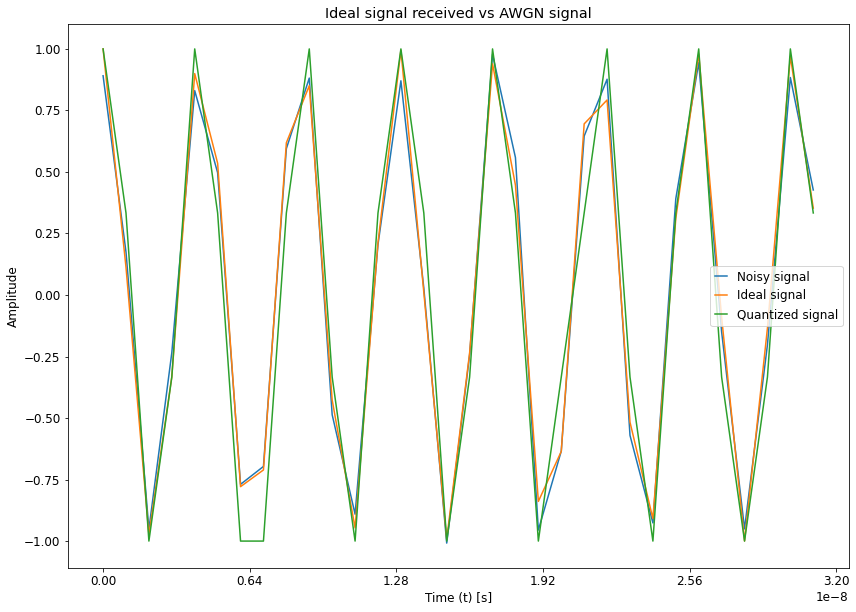

Mean Square error of quantizers is 0.0135 for linear


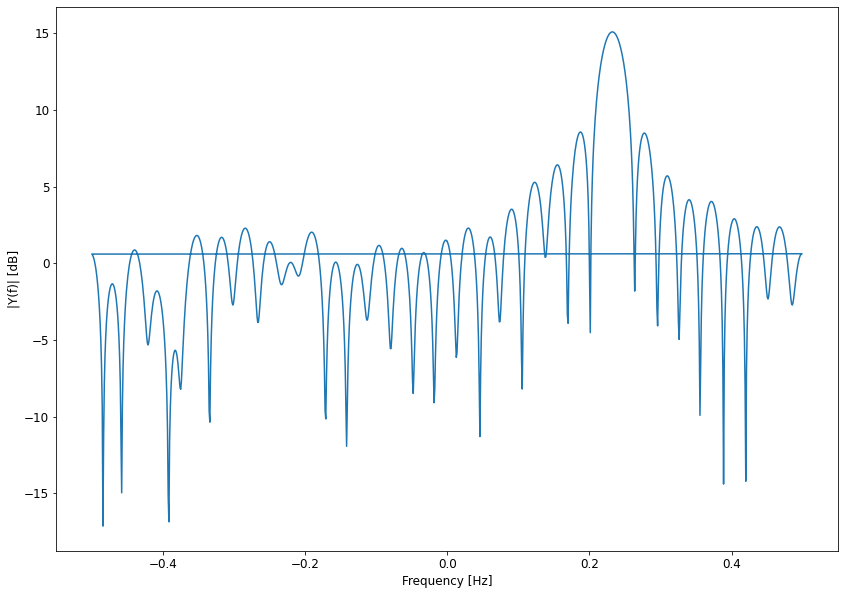

Periodogram peak frequency is 0.2322


20.767722839146515

In [8]:
# generate some ideal data
t = np.arange(0, n)/fs
x, _ = data_generator(min_fc=fc, max_fc=fc, phase_offset=0, amplitude=amplitude, n=n, fs=fs)

# add noise
x_rec, std = generate_noise(x, SNR)
# print(f"snr ={10**(calc_snr(x, x_rec)/10.0)}, also A^2/2o^2 = {amplitude**2/(2*std**2)}")
# quantize values
linear_x, lvls = general_quantizer(x_rec, bits=bits, maximum=amplitude, minimum=-amplitude)

# plot for comparison
plt.plot(t, x_rec.real, t, x.real, t, linear_x.real)
plt.title("Ideal signal received vs AWGN signal")
plt.xticks(np.arange(0, tend+1e-11, step=0.2*tend))
plt.xlabel("Time (t) [s]")
plt.ylabel("Amplitude")
plt.legend(["Noisy signal", "Ideal signal", "Quantized signal"], loc="best")
plt.show()
print(f"Mean Square error of quantizers is {mean_squared_error(np.absolute(x), np.absolute(linear_x)):.4f} for linear")

plot_spectrum(x, x_rec)

/usr/local/lib/python3.6/dist-packages/scipy/signal/spectral.py:1815: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


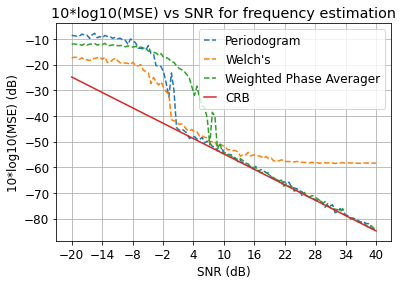

/usr/local/lib/python3.6/dist-packages/scipy/signal/spectral.py:1815: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


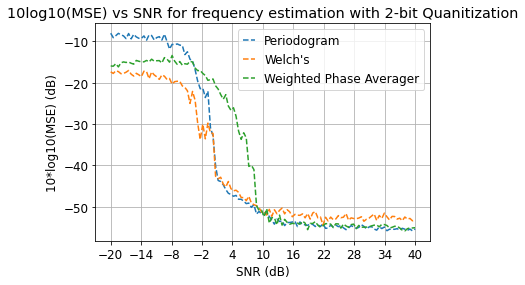

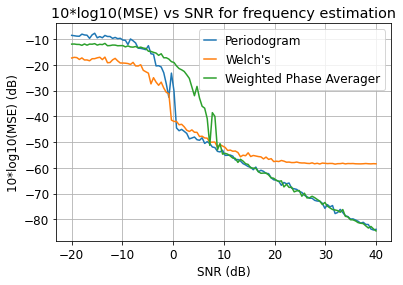

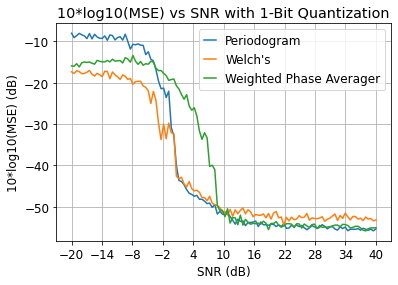

/usr/local/lib/python3.6/dist-packages/scipy/signal/spectral.py:1815: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


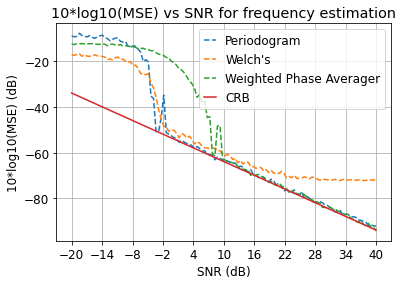

/usr/local/lib/python3.6/dist-packages/scipy/signal/spectral.py:1815: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


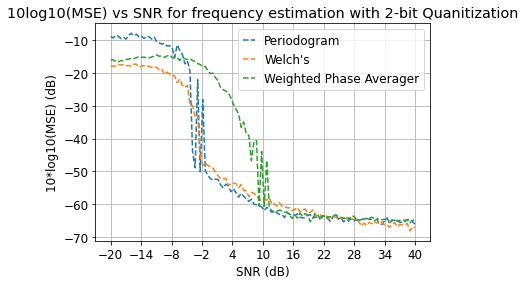

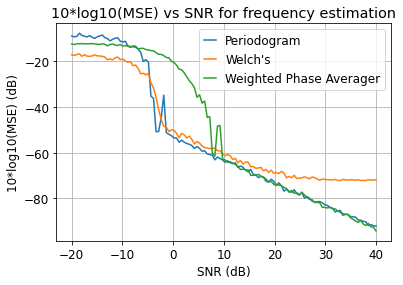

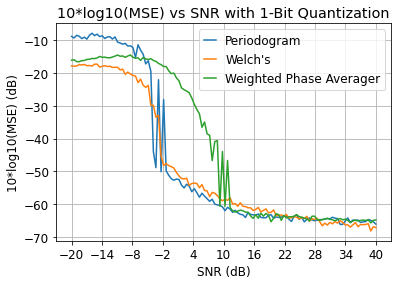

/usr/local/lib/python3.6/dist-packages/scipy/signal/spectral.py:1815: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


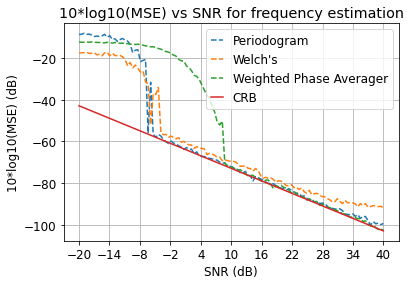

/usr/local/lib/python3.6/dist-packages/scipy/signal/spectral.py:1815: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


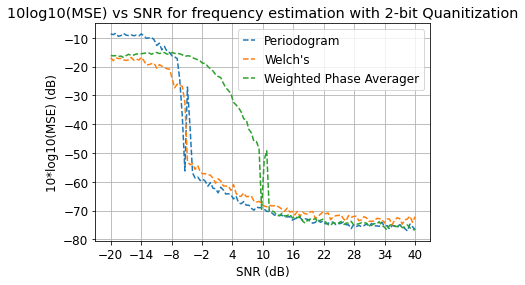

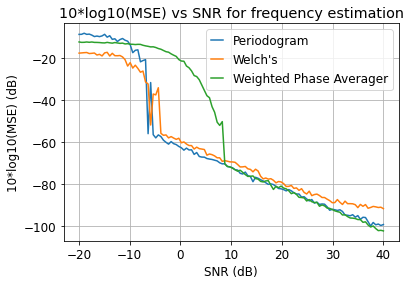

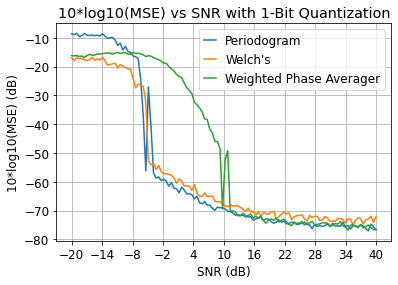

In [11]:
nset = [16, 32, 64]

for ni in nset:

    estimators = [Periodogram_estimator, Welchs_Rect_Periodogram, WPA_estimator_1]
    names = ["Periodogram", "Welch's", "Weighted Phase Averager"]
    classic_names = names

    x, _ = data_generator(min_fc=fc, max_fc=fc, amplitude=amplitude, n=ni, fs=fs)

    (snrs, mses) = plot_over_snr(x, -20, 40, fs=fs, min_fc=min_fc, max_fc=max_fc, estimators=estimators, names=names,phase=True, monte_carlos=100)
    (quant_snrs, quant_mses) = plot_over_snr(x, -20, 40, fs=fs, min_fc=min_fc, max_fc=max_fc, estimators=estimators, names=names, phase=True, quantizer=linear_quantizer, bits=bits, monte_carlos=100)
    
    for i in range(len(mses)):
        plt.plot(snrs, mses[i])

    plt.legend(names)
    plt.title(f"10*log10(MSE) vs SNR for frequency estimation")
    plt.xlabel("SNR (dB)")
    plt.ylabel("10*log10(MSE) (dB)")
    plt.grid()
    plt.show()

    for i in range(len(quant_mses)):
        plt.plot(snrs, quant_mses[i])

    plt.title(f"10*log10(MSE) vs SNR with {bits}-Bit Quantization")
    plt.xlabel("SNR (dB)")
    plt.ylabel("10*log10(MSE) (dB)")
    plt.legend(names)
    plt.grid()
    plt.xticks(np.arange(-20, 40+1.0e-5, step=0.1*(40+20)))
    plt.show()

## Timing Results

This section is used to test how quickly estimators work. Ordinarily, deep learning is assumed to be very slow, however, specialized hardware can execute neural networks very quickly, even compared to high accuracy FFTs

In [ ]:
!pip install pycuda
!pip install scikit-cuda
import pycuda.autoinit
import pycuda.gpuarray as gpuarray
import skcuda.fft as cu_fft

In [10]:
#@title Matrix version estimators
# implement matrix input versions of the estimators
def Periodogram_estimator_Matrix(data):
    """
    Implements the MLE error for frequency estimation, which is the periodogram method
    :param data: input time domain data
    :param fs: sampling frequency
    :return: highest frequency peak of the periodogram
    """
    first_d = data.shape[0]
    length = 2**12
    dfft = np.absolute(fft(np.complex128(data), n=length), dtype=np.float128)
    frequencies = np.fft.fftfreq(length)
    interp = False
    mle_freqs = np.zeros((first_d, 1))

    # interpolate from top 3 frequencies

    for k in range(first_d):
        idx = np.argmax(dfft[i, :])
    
        if interp is True:
            if idx == length-1:
                mle_freq = frequencies[idx]

            else:
                indices = [idx-1, idx, idx+1]
                freqs = frequencies[indices].astype(np.float64)
                values = np.abs(dfft[indices]).astype(np.float64)

                mle_freq[i] = interpolation(freqs, values)
        else:
            mle_freqs[i] = frequencies[idx]
        
    return mle_freqs

def Welchs_Rect_Periodogram_Matrix(data):
    """
    Implements the MLE error for frequency estimation, which is the periodogram method
    :param data: input time domain data
    :param fs: sampling frequency
    :return: highest frequency peak of the periodogram
    """
    first_d = data.shape[0]
    length = 2**12

    frequencies, dfft = scipy.signal.welch(data, nfft=length, window='boxcar', nperseg=data.shape[1]//2)
    mle_freqs = np.zeros((first_d, 1))
    interp = False

    # interpolate from top 3 frequencies
    for i in range(first_d):
        idx = np.argmax(np.abs(dfft[i, :]))
        
        if interp is True:
            if idx == length-1:
                mle_freqs[i] = frequencies[idx]

            else:
                indices = [idx-1, idx, idx+1]
                freqs = frequencies[indices].astype(np.float64)
                values = np.abs(dfft[i, indices]).astype(np.float64)

                mle_freqs[i] = interpolation(freqs, values)
        else:
            mle_freqs[i] = mle_freqs[i] = frequencies[idx]
        
    return mle_freqs


def fft2_gpu(x, length, fftshift=False):
    
    ''' This function produce an output that is 
    compatible with numpy.fft.fft2
    The input x is a 2D numpy array'''
    x = np.pad(datam, [(0, length-len(x)), [0, 0]])
    # Convert the input array to single precision float
    if x.dtype != 'float32':
        x = x.astype('float32')
    # Get the shape of the initial numpy array
    n1, n2 = x.shape

    N = n1
    batch_size = n2
    x_gpu = gpuarray.to_gpu(x)
    xf_gpu = gpuarray.empty((batch_size, N//2+1), np.complex64)
    plan_forward = cu_fft.Plan(N, np.float32, np.complex64, batch_size)
    cu_fft.fft(x_gpu, xf_gpu, plan_forward)

    y = xf_gpu.get()
    
    return y.astype('complex128')

In [15]:
num_tests = 100
n = 32

t = np.arange(0, n)/fs
x, _ = data_generator(min_fc=fc, max_fc=fc, phase_offset=0, amplitude=amplitude, n=n, fs=fs)

# add noise
x_rec, std = generate_noise(x, SNR)


datam = np.array([])
for i in range(num_tests):
    datam = np.append(datam, x_rec)
datam = datam.reshape(num_tests, n).astype(np.float32)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  


In [16]:
# CPU Periodogram
print("Periodogram")
%timeit -n 50 Periodogram_estimator_Matrix(datam)

# GPU Periodogram
print("\nPeriodogram GPU")
%timeit -n 50 -r 3 fft2_gpu(datam, 2**15, fftshift=True)

# Welch's method
print("\nWelch's Method")
%timeit -n 50 Welchs_Rect_Periodogram_Matrix(datam)

# MUSIC
print("\nMUSIC")
%timeit -n 50 [Music_estimator(x_rec) for i in range(num_tests)] 

Periodogram
50 loops, best of 3: 26.8 ms per loop

Periodogram GPU
50 loops, best of 3: 4.83 ms per loop

Welch's Method
50 loops, best of 3: 14.3 ms per loop

MUSIC
50 loops, best of 3: 355 ms per loop


## Deep Learning Estimators

In [ ]:
default_Dense = partial(keras.layers.Dense, activation='relu', kernel_initializer='he_normal')
default_Conv = partial(keras.layers.Conv1D, kernel_size=3, strides = 1, padding='SAME', activation='relu')

def FCC(outputs=1):
    net1 = keras.models.Sequential([
                keras.layers.InputLayer((ni, 2)),
                keras.layers.Flatten(),
                default_Dense(1024),
                default_Dense(512),
                default_Dense(256),
                default_Dense(128),
                default_Dense(64),
                default_Dense(32),
                keras.layers.Dense(outputs)
            ])
    return net1

def CNN(outputs=1):
    net2 = keras.models.Sequential([
                keras.layers.InputLayer((ni, 2)),
                default_Conv(8),
                default_Conv(16),
                default_Conv(32),
                default_Conv(64),
                default_Conv(128),
                default_Conv(256),
                keras.layers.Flatten(),
                default_Dense(128),
                default_Dense(64),
                keras.layers.Dense(outputs),
            ])
    return net2

def RNN(outputs=1):
    net3 = keras.models.Sequential([
                keras.layers.InputLayer((ni, 2)),
                keras.layers.LSTM(16, return_sequences=True),
                keras.layers.LSTM(32, return_sequences=True),
                keras.layers.LSTM(64),
                keras.layers.Flatten(),
                default_Dense(128),
                default_Dense(64),
                keras.layers.Dense(outputs),
            ])
    return net3

def ResidualNet(outputs=1):
    net4 = keras.models.Sequential([
                keras.layers.InputLayer((ni, 2)),
                default_Conv(8),
                ResUnit(16, use_1x1=True),
                ResUnit(32, use_1x1=True),
                ResUnit(64, use_1x1=True),
                ResUnit(128, use_1x1=True),
                ResUnit(256, use_1x1=True),
                keras.layers.Flatten(),
                default_Dense(128),
                default_Dense(64),
                keras.layers.Dense(outputs),
            ])
    return net4

network_gen = [FCC, CNN, RNN, ResidualNet]
DL_names = ["ANN", "CNN", "RNN", "Residual"]

early_stopping = keras.callbacks.EarlyStopping(patience=12, restore_best_weights = True)
lr_reduc = tf.keras.callbacks.ReduceLROnPlateau(patience=4, factor=0.5, verbose=0, min_lr=8e-6)
callbacks = [early_stopping, lr_reduc]

### Model Training

In [ ]:
## Automated Model Training for each n
nset = [8, 16]
path = '/'

size = 5000
min_snr = 0
max_snr= 10
bits = 1
batch_size = 8
MC_results = 2000
quantizing = True



net_sel = 1

def multi_est_model(data):
    data = np.array(data)
    datam = np.array([])
    for i in range(len(data)):
        datam = np.append(datam, convert_complex_to_real(data[i]))
    results = model.predict(datam.reshape(len(data), ni, 2))
    return results

    
for ni in nset:
    # Data generation
    model_path = path+'Models/'+str(ni)+"-point/"

    print(f"Starting n={ni}")
    x, _ = data_generator(min_fc=min_fc, max_fc=max_fc, phase_offset=0, amplitude=amplitude, n=ni, fs=fs)

    dataset, freqs = build_dataset(min_fc=fs/5.0, max_fc=fs/4.0, size=size, fs=fs, phase_offset=True, n=ni, min_snr=min_snr, max_snr=max_snr, split_real_imag=True, quantizer=quantizing)
    dataset = dataset.reshape(size, ni, 2).astype(np.float32)
    freqs = np.asarray(freqs, dtype=np.float32)

    validation_size = 0.20             # 20% test size
    x_train, x_test, y_train, y_test = model_selection.train_test_split(dataset, freqs, test_size=validation_size, random_state=seed)

    train = tf.data.Dataset.from_tensor_slices((x_train.astype(np.float32), y_train.astype(np.float32))).batch(batch_size).shuffle(10000).cache()
    test = tf.data.Dataset.from_tensor_slices((x_test.astype(np.float32), y_test.astype(np.float32))).batch(batch_size)

    train = train.prefetch(tf.data.experimental.AUTOTUNE)
    test = test.prefetch(tf.data.experimental.AUTOTUNE)


    for nsel in range(len(nsel)):
        model = network_gen[nsel]()

            # Model naming
            if quantizing:
                name1 = 'Q_' + 'b' +str(bits) + DL_names[nsel] + str(min_snr) + '-' + str(max_snr) + '.h5py'
            else:
                name1 = DL_names[nsel] + str(min_snr) + '-' + str(max_snr) + '.h5py'

            optimizer = tf.keras.optimizers.Adam(1e-4)
            model.compile(loss='mse', optimizer=optimizer)
            model.summary()

        # Model Training
        model.fit(train, validation_data=test, epochs=100, callbacks=callbacks)
        model.evaluate(test)

        model_path = path+'Models/'+str(ni)+"-point/"
        print(f"Saving to {model_path}")

        model_name1 = model_path + name1
        model.save(model_name1)
        
        msepath = path+"MSES/"+str(ni)+"-point/"
        DL_path = msepath + name1[:-4] + "pickle"

        (dlsnrs, dlmses) = plot_over_snr_DL(x, -20, 40, fs=fs, min_fc=min_fc, max_fc=max_fc, phase=True, estimators=[multi_est_model], names=["DL"], monte_carlos=MC_results)
        (quant_dlsnrs, quant_dlmses) = plot_over_snr_DL(x, -20, 40, fs=fs, min_fc=min_fc, max_fc=max_fc, estimators=[multi_est_model], names=["DL"], phase=True, quantizer=linear_quantizer, bits=bits, monte_carlos=MC_results)
        
        filen = open(DL_path, "wb")
        pickle.dump([(dlsnrs, dlmses), (quant_dlsnrs, quant_dlmses)], filen )
        filen.close()

## Load and Evaluate Models

Overall results for N=16 comparing classical and deep learning estimators

Using classics, make sure you have 7 markers


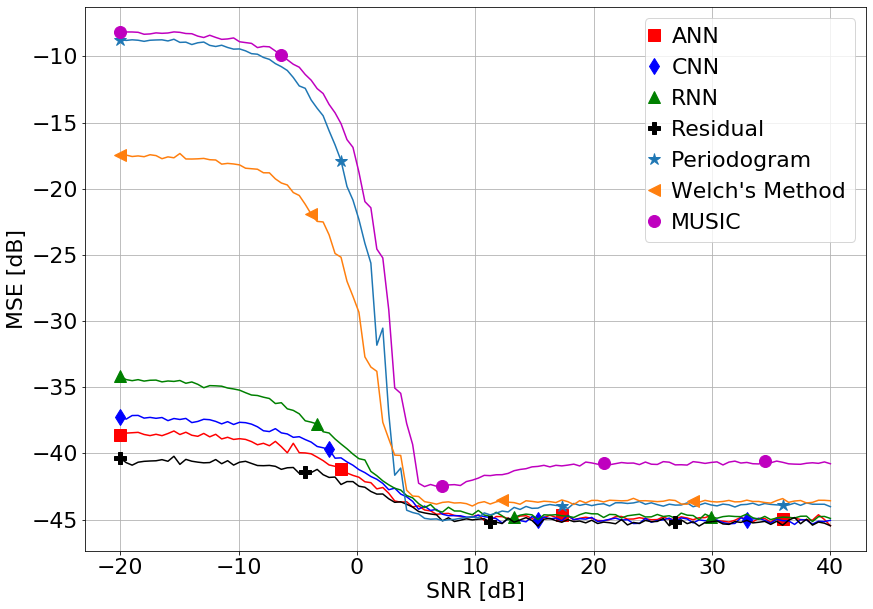

In [ ]:
ANN_name = 'ANN_snr_0-10.pickle'
CNN_name = 'CNN_snr_0-10.pickle'
RNN_name = 'RNN_snr_0-10.pickle'
Res_name = 'Residual_snr_0-10.pickle'

list_names3 = [ANN_name, CNN_name, RNN_name]
names3 = ["ANN", "CNN", "RNN"]
list_names4 = [ANN_name, CNN_name, RNN_name, Res_name]
names4 = ["ANN", "CNN", "RNN", "Residual"]
nset = [16]
markset = [['rs-', 'bd-', 'g^-', 'kP-', '*-', '<-', 'mo-']]

nset_plot(list_names4, "NN Estimators Compared to Classic Estimators", names4, nset=nset, markerset=markset, classics=True)

Results for comparing the deep learning estimators with different pilot lengths

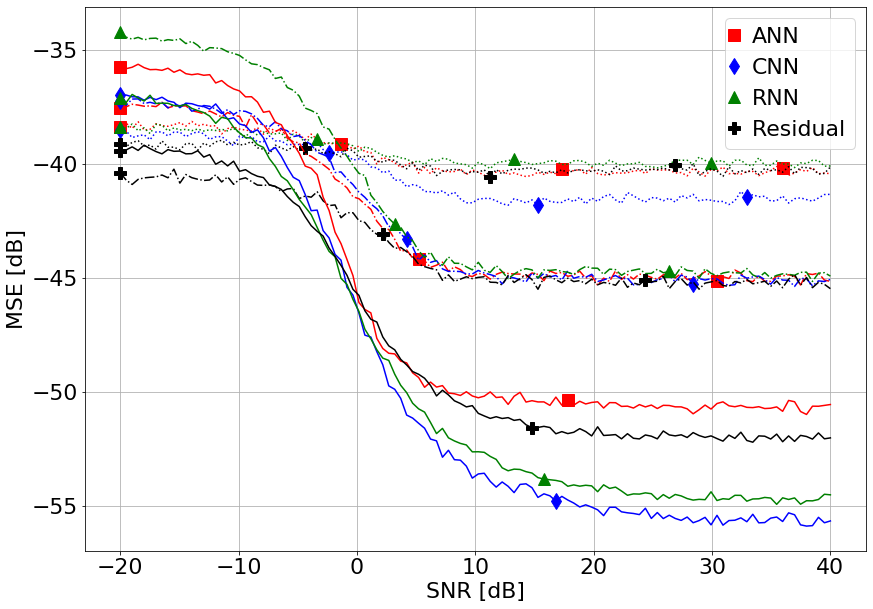

In [ ]:
ANN_name = 'ANN_snr_0-10.pickle'
CNN_name = 'CNN_snr_0-10.pickle'
RNN_name = 'RNN_snr_0-10.pickle'
Res_name = 'Residual_snr_0-10.pickle'

list_names3 = [ANN_name, CNN_name, RNN_name]
names3 = ["ANN", "CNN", "RNN"]
list_names4 = [ANN_name, CNN_name, RNN_name, Res_name]
names4 = ["ANN", "CNN", "RNN", "Residual"]

markset = [['rs:', 'bd:', 'g^:', 'kP:'], ['rs-.', 'bd-.', 'g^-.', 'kP-.'], ['rs-', 'bd-', 'g^-', 'kP-']]

nset_plot(list_names4, "Unquant low SNR", names4, markerset=markset, classics=False)

Results for comparing versus training SNR

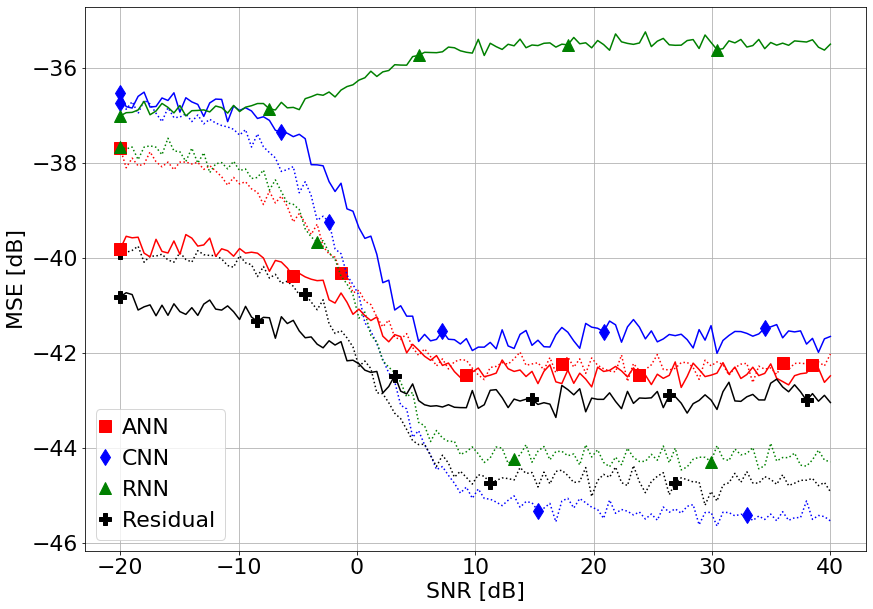

In [ ]:
# want to plot 4 sets of 2 estimators
ANN_name = 'ANN_snr_0-10.pickle'
CNN_name = 'CNN_snr_0-10.pickle'
RNN_name = 'RNN_snr_0-10.pickle'
Res_name = 'Residual_snr_0-10.pickle'

ANN_name = 'ANN_snr_10-20.pickle'
CNN_name = 'CNN_snr_10-20.pickle'
RNN_name = 'RNN_snr_10-20.pickle'
Res_name = 'Residual_snr_10-20.pickle'

markset = [['rs:', 'bd:', 'g^:', 'kP:', 'rs-', 'bd-', 'g^-', 'kP-']]
estims = [ANN_name, CNN_name, RNN_name, Res_name, ANN_name2, CNN_name2, RNN_name2, Res_name2]
names = ["ANN", "CNN", "RNN", "Residual"]

nset_plot(estims, "NN MSE with Low and High SNR Training", name=names, nset=[16], markerset=markset, classics=False)

Finally, comparing versus training quantization

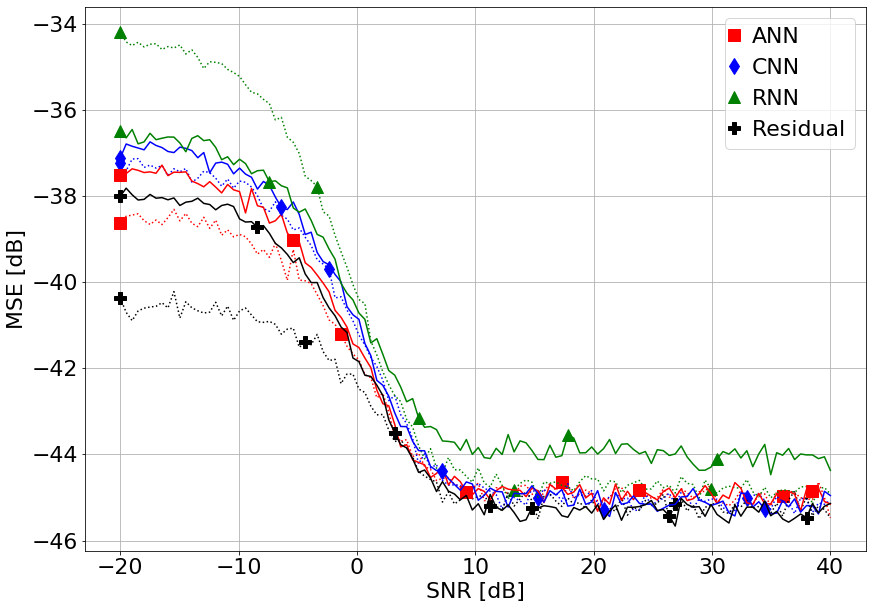

In [ ]:
# want to plot 4 sets of 2 estimators
ANN_name = 'ANN_snr_0-10.pickle'
CNN_name = 'CNN_snr_0-10.pickle'
RNN_name = 'RNN_snr_0-10.pickle'
Res_name = 'Residual_snr_0-10.pickle'

ANN_name = 'Q_1b_ANN_snr_0-10.pickle'
CNN_name = 'Q_1b_CNN_snr_0-10.pickle'
RNN_name = 'Q_1b_RNN_snr_0-10.pickle'
Res_name = 'Q_1b_Residual_snr_0-10.pickle'

markset = [['rs:', 'bd:', 'g^:', 'kP:', 'rs-', 'bd-', 'g^-', 'kP-']]

estims = [ANN_name, CNN_name, RNN_name, Res_name, ANN_name2, CNN_name2, RNN_name2, Res_name2]
names = ["ANN", "CNN", "RNN", "Residual"]

nset_plot(estims, "NN Performance with Quantized/Unquantized Training", name=names, nset=[16], markerset=markset)